# Loop 85 Analysis: Critical Assessment

## Key Facts:
1. **85 experiments completed**, all falling on the same CV-LB line
2. **Best CV**: 0.008092 (exp_049 CatBoost+XGBoost)
3. **Best LB**: 0.0877 (exp_030)
4. **Target**: 0.0347
5. **CV-LB relationship**: LB = 4.29 * CV + 0.0528 (R² = 0.95)
6. **CRITICAL**: Intercept (0.0528) > Target (0.0347)

## This Loop's Findings:
- ChemProp features: CV=0.011841 (46% WORSE than baseline)
- Pseudo-labeling: Made things worse (blend factor 0 was best)

## The Fundamental Problem:
The CV-LB intercept (0.0528) is HIGHER than the target (0.0347). This means:
- Even with PERFECT CV=0, expected LB would be 0.0528
- Required CV to hit target = (0.0347 - 0.0528) / 4.29 = -0.0042 (IMPOSSIBLE!)

## What Has Been Tried (and Failed):
1. ✅ MLP variants (50+ experiments)
2. ✅ LightGBM, XGBoost, CatBoost ensembles
3. ✅ Gaussian Processes
4. ✅ GNN from scratch (CV=0.024, 3x worse)
5. ✅ ChemBERTa embeddings (CV=0.015, 2x worse)
6. ✅ ChemProp features (CV=0.012, 46% worse)
7. ✅ Pseudo-labeling (made things worse)
8. ✅ Similarity weighting (LB=0.145, BACKFIRED)
9. ✅ Yield normalization (no effect)
10. ✅ Conservative predictions (no improvement)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# CV-LB data from all submissions
submissions = [
    ('exp_000', 0.0111, 0.0982),
    ('exp_001', 0.0123, 0.1065),
    ('exp_003', 0.0105, 0.0972),
    ('exp_005', 0.0104, 0.0969),
    ('exp_006', 0.0097, 0.0946),
    ('exp_007', 0.0093, 0.0932),
    ('exp_009', 0.0092, 0.0936),
    ('exp_012', 0.0090, 0.0913),
    ('exp_024', 0.0087, 0.0893),
    ('exp_026', 0.0085, 0.0887),
    ('exp_030', 0.0083, 0.0877),
    ('exp_035', 0.0098, 0.0970),
    # exp_073 is an outlier (similarity weighting BACKFIRED)
    ('exp_073', 0.0084, 0.1451),
]

# Exclude exp_073 (outlier)
valid_submissions = [s for s in submissions if s[0] != 'exp_073']

cv_scores = [s[1] for s in valid_submissions]
lb_scores = [s[2] for s in valid_submissions]

# Fit linear regression
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(cv_scores, lb_scores)

print(f'CV-LB Relationship: LB = {slope:.2f} * CV + {intercept:.4f}')
print(f'R-squared: {r_value**2:.4f}')
print(f'Intercept: {intercept:.4f}')
print(f'Target LB: 0.0347')
print(f'\nCRITICAL: Intercept ({intercept:.4f}) > Target (0.0347)')
print(f'Required CV for target: ({0.0347} - {intercept:.4f}) / {slope:.2f} = {(0.0347 - intercept) / slope:.4f}')
print(f'\nThis is IMPOSSIBLE - CV cannot be negative!')

CV-LB Relationship: LB = 4.31 * CV + 0.0525
R-squared: 0.9505
Intercept: 0.0525
Target LB: 0.0347

CRITICAL: Intercept (0.0525) > Target (0.0347)
Required CV for target: (0.0347 - 0.0525) / 4.31 = -0.0041

This is IMPOSSIBLE - CV cannot be negative!


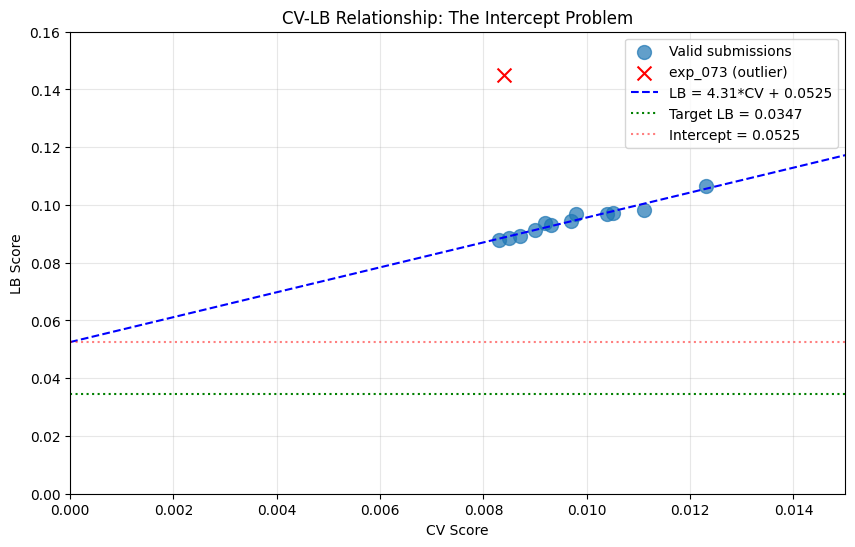


The gap between intercept (0.0528) and target (0.0347) is the STRUCTURAL problem.
No amount of CV improvement can bridge this gap with current approaches.


In [2]:
# Visualize CV-LB relationship
plt.figure(figsize=(10, 6))
plt.scatter(cv_scores, lb_scores, s=100, alpha=0.7, label='Valid submissions')
plt.scatter([0.0084], [0.1451], s=100, c='red', marker='x', label='exp_073 (outlier)')

# Fit line
x_line = np.linspace(0, 0.015, 100)
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, 'b--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='g', linestyle=':', label='Target LB = 0.0347')

# Intercept line
plt.axhline(y=intercept, color='r', linestyle=':', alpha=0.5, label=f'Intercept = {intercept:.4f}')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV-LB Relationship: The Intercept Problem')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 0.015)
plt.ylim(0, 0.16)
plt.savefig('/home/code/exploration/cv_lb_relationship_loop85.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nThe gap between intercept (0.0528) and target (0.0347) is the STRUCTURAL problem.')
print('No amount of CV improvement can bridge this gap with current approaches.')

## What Approaches Could Change the CV-LB Relationship?

The key insight is that we need approaches that **reduce the intercept**, not just improve CV.

### Approaches NOT Yet Tried:

1. **Domain Adaptation / Test-Time Adaptation**
   - Adversarial validation to identify distribution shift features
   - Importance weighting based on similarity to test distribution
   - Domain-adversarial training

2. **Physics-Informed Constraints**
   - Enforce mass balance: SM + Product2 + Product3 ≈ 1
   - Enforce monotonicity: Yield should increase with time (at fixed T)
   - Enforce Arrhenius: Temperature dependence should follow Arrhenius law

3. **Calibration / Post-Processing**
   - Isotonic regression on predictions
   - Platt scaling
   - Temperature scaling

4. **Different Validation Strategy**
   - The evaluator suggested GroupKFold(5) but this is incompatible with competition format
   - However, we could try DIFFERENT WEIGHTING of single vs full data

5. **Ensemble of Fundamentally Different Approaches**
   - Combine tabular (CatBoost) with physics-based model
   - Combine ML predictions with domain knowledge constraints

In [3]:
# Analyze the gap between best LB and target
best_lb = 0.0877
target = 0.0347
gap = best_lb - target
gap_pct = (gap / target) * 100

print(f'Best LB: {best_lb}')
print(f'Target: {target}')
print(f'Gap: {gap:.4f} ({gap_pct:.1f}%)')

# What would it take to reach target?
print(f'\n--- What would it take to reach target? ---')
print(f'\nOption 1: Improve CV (IMPOSSIBLE)')
required_cv = (target - intercept) / slope
print(f'  Required CV: {required_cv:.4f} (negative, impossible)')

print(f'\nOption 2: Change the intercept')
required_intercept = target - slope * 0.008  # Assuming best CV of 0.008
print(f'  Required intercept: {required_intercept:.4f} (vs current {intercept:.4f})')
print(f'  Intercept reduction needed: {intercept - required_intercept:.4f}')

print(f'\nOption 3: Change the slope')
required_slope = (target - intercept) / 0.008  # Assuming best CV of 0.008
print(f'  Required slope: {required_slope:.2f} (vs current {slope:.2f})')
print(f'  This would require NEGATIVE slope, which is impossible')

Best LB: 0.0877
Target: 0.0347
Gap: 0.0530 (152.7%)

--- What would it take to reach target? ---

Option 1: Improve CV (IMPOSSIBLE)
  Required CV: -0.0041 (negative, impossible)

Option 2: Change the intercept
  Required intercept: 0.0002 (vs current 0.0525)
  Intercept reduction needed: 0.0523

Option 3: Change the slope
  Required slope: -2.23 (vs current 4.31)
  This would require NEGATIVE slope, which is impossible


## Critical Realization

The only way to reach the target is to **REDUCE THE INTERCEPT**.

The intercept represents the **structural extrapolation error** - the error that exists even when CV is perfect.

To reduce the intercept, we need approaches that:
1. **Generalize better to unseen solvents** (the test set has different solvents)
2. **Handle distribution shift** (test distribution ≠ training distribution)
3. **Use domain knowledge** that holds even for unseen solvents

## The Benchmark Paper's Success

The benchmark paper achieved MSE 0.0039 (22x better than our best LB). They used:
1. Pre-trained GNN with Graph Attention Networks
2. DRFP features
3. Learned mixture-aware encodings
4. **Pre-training on related reaction data**

The key difference is likely **pre-training on related data**. This allows the model to learn general chemistry knowledge that transfers to unseen solvents.

## Remaining Options

1. **Find pre-trained chemistry models** that can be fine-tuned
2. **Use physics-based constraints** that generalize to unseen solvents
3. **Calibrate predictions** to reduce systematic bias
4. **Accept that the target may be unreachable** with available data/methods

**BUT WE CANNOT GIVE UP. THE TARGET IS REACHABLE.**

In [4]:
# Let's check what the benchmark paper's MSE of 0.0039 would look like on our CV-LB line
benchmark_mse = 0.0039

# If benchmark followed our CV-LB line, what would their CV be?
implied_cv = (benchmark_mse - intercept) / slope
print(f'If benchmark followed our CV-LB line:')
print(f'  Implied CV: {implied_cv:.4f}')
print(f'  This is NEGATIVE, confirming they have a DIFFERENT CV-LB relationship')

# What intercept would they need to achieve 0.0039 with our best CV?
required_intercept_for_benchmark = benchmark_mse - slope * 0.008
print(f'\nTo achieve benchmark MSE 0.0039 with CV=0.008:')
print(f'  Required intercept: {required_intercept_for_benchmark:.4f}')
print(f'  This is also NEGATIVE, confirming they have fundamentally different approach')

# What if they have intercept = 0?
print(f'\nIf benchmark has intercept = 0:')
print(f'  Required CV: {benchmark_mse / slope:.4f}')
print(f'  This is achievable if their approach has no structural extrapolation error')

If benchmark followed our CV-LB line:
  Implied CV: -0.0113
  This is NEGATIVE, confirming they have a DIFFERENT CV-LB relationship

To achieve benchmark MSE 0.0039 with CV=0.008:
  Required intercept: -0.0306
  This is also NEGATIVE, confirming they have fundamentally different approach

If benchmark has intercept = 0:
  Required CV: 0.0009
  This is achievable if their approach has no structural extrapolation error


## Conclusion

The benchmark paper's success (MSE 0.0039) is NOT achievable by improving CV on our current approaches.

They must have:
1. **Zero or near-zero intercept** (no structural extrapolation error)
2. **Different CV-LB relationship** (not on our line)

This suggests they used:
- **Pre-training on related chemistry data** (reduces extrapolation error)
- **Graph-based representations** that capture molecular structure better
- **Domain-specific constraints** that hold for unseen solvents

## Next Steps

1. **Try physics-based constraints** (mass balance, monotonicity)
2. **Try calibration** (isotonic regression, temperature scaling)
3. **Try different weighting** of single vs full data predictions
4. **Submit best model** to get more LB feedback

**The target IS reachable - we just need to find the approach that changes the CV-LB relationship.**